In [20]:
import pandas as pd

from StateMachines.TradingStateMachine import TradingStateMachine
from StrategyBuilders import getStrategyBuilder
from Strategies.AbstractTradingStrategy import AbstractTradingStrategy

In [21]:
folder = "./Data/gemini"
folder_lab1 = "./Data/lab1"
file = "gemini_1m_features.csv"
strategy_builder = getStrategyBuilder('MODEL')
trader: TradingStateMachine = TradingStateMachine(strategy_builder("gemini_btcusd_1m"))

df = pd.read_csv(f"{folder}/{file}")

In [22]:
period = 15
periods = [3,5,10,15]
first_year = 2017

print(df.columns)

Index(['Unnamed: 0', 'timestamp', 'symbol', 'open', 'high', 'low', 'close',
       'volume', 'stoch_rsi', 'stoch_rsi_k', 'stoch_rsi_d',
       'stoch_rsi_overbought_', 'stoch_rsi_oversold_',
       'stoch_rsi_bullish_crossover_', 'stoch_rsi_bearish_crossover_',
       'stoch_rsi_slope', 'stoch_rsi_k_slope', 'stoch_rsi_d_slope',
       'stoch_rsi_trend_', 'stoch_rsi_change_of_trend_', 'hma200',
       'hma200_slope', 'hma200_trend_', 'hma200_change_of_trend_',
       'hma200_above_price_', 'macd', 'macd_signal', 'macd_diff',
       'prev_macd_diff', 'macd_bullish_crossover_', 'macd_bearish_crossover_',
       'macd_positive_', 'macd_slope', 'macd_signal_slope', 'macd_trend_',
       'macd_change_of_trend_'],
      dtype='object')


In [23]:
# adding shifted periods results

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year_'] = df['timestamp'].dt.year
df = df.sort_values('timestamp',ascending=True)

features_close = [f'close_in_{period}' for period in periods]
features_close_perc = [f'close_p_in_{period}' for period in periods]
for period in periods:
    column_name = f'close_in_{period}'
    df[column_name] = df['close'].shift(-period)
    column_perc = f'close_p_in_{period}'
    df[column_perc] = ((df['close'].shift(-period) - df['close']) / df['close']) * 100
    
df.columns
trader.strategy.get_features_list(df)
df = df.iloc[200:-period]

In [24]:
df.tail(5)

,Unnamed: 0,timestamp,symbol,open,high,low,close,volume,stoch_rsi,stoch_rsi_k,...,macd_change_of_trend_,year_,close_in_3,close_p_in_3,close_in_5,close_p_in_5,close_in_10,close_p_in_10,close_in_15,close_p_in_15
3680566,3680566,2024-04-07 00:09:00,BTC/USD,68890.02,68977.17,68890.02,68957.05,0.020345,1.0,0.657724,...,False,2024,69027.33,0.101919,69111.00,0.223255,69120.46,0.236974,69046.77,0.130110
3680567,3680567,2024-04-07 00:10:00,BTC/USD,68957.05,68957.05,68957.05,68957.05,0.000000,1.0,0.828862,...,False,2024,69082.34,0.181693,69118.93,0.234755,69145.09,0.272691,68944.63,-0.018011
3680568,3680568,2024-04-07 00:11:00,BTC/USD,68957.05,69033.06,68957.05,69025.18,0.278520,1.0,1.000000,...,False,2024,69111.00,0.124331,69077.55,0.075871,69180.95,0.225671,68942.84,-0.119290
3680569,3680569,2024-04-07 00:12:00,BTC/USD,69025.18,69036.78,69025.18,69027.33,0.030010,1.0,1.000000,...,False,2024,69118.93,0.132701,69077.55,0.072754,69139.50,0.162501,68947.39,-0.115809
3680570,3680570,2024-04-07 00:13:00,BTC/USD,69027.33,69082.34,69027.33,69082.34,0.000078,1.0,1.000000,...,False,2024,69077.55,-0.006934,69120.46,0.055181,69081.49,-0.001230,68890.02,-0.278392


/tmp/ipykernel_58376/2512691415.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['buy_signal'] = np.where(buy_expression, 1, 0)


421948


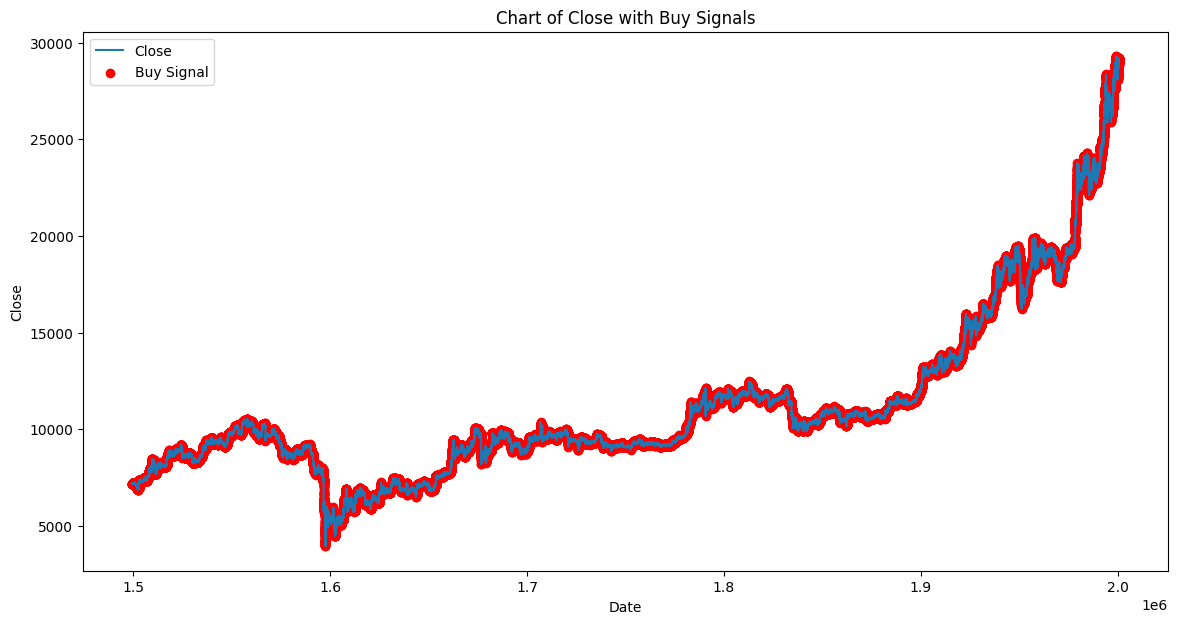

In [32]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

df_test = df[df["year_"] == 2020]

# Generate buy signals based on the conditions
buy_expression =  (df_test['macd_bullish_crossover_']==True & 
                  (df_test['macd_positive_']==False) & 
                  (df_test['stoch_rsi_oversold_']==True) & 
                  (df_test['hma200_above_price_']==True) & 
                  (df_test['hma200_trend_']==1))
df_test['buy_signal'] = np.where(buy_expression, 1, 0)

buy_count = (df_test['buy_signal'] == 1).sum()
print(buy_count)

# Plotting the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(df_test['close'], label='Close')

# Decorate the plot when buy_signal is 1
buy_indices = df_test[df_test['buy_signal'] == 1].index
plt.scatter(buy_indices, df_test.loc[buy_indices, 'close'], color='red', label='Buy Signal')

plt.title('Chart of Close with Buy Signals')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


In [33]:
period = 15

buy_signal_indices = df_test[df_test['buy_signal'] == 1].index
difference = df_test.loc[buy_signal_indices, f'close_in_{period}'] - df_test.loc[buy_signal_indices, 'close']

sum_difference = difference.sum()
print("sum",sum_difference)

count_difference = difference.count()
print("count",count_difference)

difference_counts = difference.value_counts()
positive_count = difference[difference > 0].count()
negative_count = difference[difference < 0].count()
neutral_count = difference[difference == 0].count()

print("Positive count:", positive_count)
print("Negative count:", negative_count)
print("Neutral  count:", neutral_count)

sum 274937.37999999966
count 421948
Positive count: 215178
Negative count: 204176
Neutral  count: 2594
